In [ ]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.use_inf_as_na = True



%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Рассмотрим пример с данными


**Линейная регрессия** &mdash; это модель следующего вида:
$$a(x) = \langle w, x \rangle + w_0$$
где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. Обучить линейную регрессию &mdash; значит найти $w = [w_1, w_2, ... , w_n]$ и $w_0$.

- MedInc: Медианная доходность района.
- HouseAge: Медианный возраст домов в районе.
- AveRooms: Среднее количество комнат в доме.
- AveBedrms: Среднее количество спален в доме.
- Population: Общая численность населения в районе.
- AveOccup: Среднее количество людей, проживающих в доме.
- Latitude: Широта координаты района.
- Longitude: Долгота координаты района.



Target (также называется MedHouseVal): Медианная стоимость домов в районе (целевая переменная).

In [ ]:
data = fetch_california_housing(as_frame=True)
df = data.frame

In [ ]:
df.drop(columns=['Longitude', 'Latitude'], inplace=True)

In [ ]:
target = df.MedHouseVal

In [ ]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'MedHouseVal'],
      dtype='object')

In [ ]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,MedHouseVal
0,8.33,41.00,6.98,1.02,322.00,2.56,4.53
1,8.30,21.00,6.24,0.97,2401.00,2.11,3.58
2,7.26,52.00,8.29,1.07,496.00,2.80,3.52
3,5.64,52.00,5.82,1.07,558.00,2.55,3.41
4,3.85,52.00,6.28,1.08,565.00,2.18,3.42
...,...,...,...,...,...,...,...
20635,1.56,25.00,5.05,1.13,845.00,2.56,0.78
20636,2.56,18.00,6.11,1.32,356.00,3.12,0.77
20637,1.70,17.00,5.21,1.12,1007.00,2.33,0.92
20638,1.87,18.00,5.33,1.17,741.00,2.12,0.85


In [ ]:
# названия столбцов приведем к lowecase
df.columns=[col.lower() for col in df.columns]

In [ ]:
df.head()

,medinc,houseage,averooms,avebedrms,population,aveoccup,medhouseval
0,8.33,41.00,6.98,1.02,322.00,2.56,4.53
1,8.30,21.00,6.24,0.97,2401.00,2.11,3.58
2,7.26,52.00,8.29,1.07,496.00,2.80,3.52
3,5.64,52.00,5.82,1.07,558.00,2.55,3.41
4,3.85,52.00,6.28,1.08,565.00,2.18,3.42


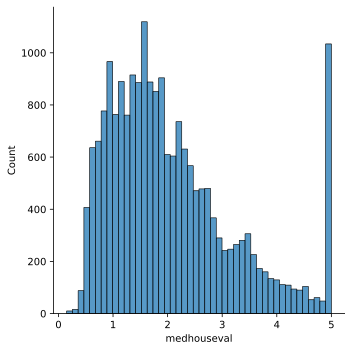

In [ ]:
sns.displot(df.medhouseval)

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам.

In [ ]:
df['medhouseval'].describe(percentiles=[0.1, 0.25, 0.75, 0.95 ])

count   20640.00
mean        2.07
std         1.15
min         0.15
10%         0.82
25%         1.20
50%         1.80
75%         2.65
95%         4.90
max         5.00
Name: medhouseval, dtype: float64

In [ ]:
# убираем выбросы
Q3 = np.quantile(df['medhouseval'], 0.75, axis=0)
Q1 = np.quantile(df['medhouseval'], 0.25, axis=0)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR
df = df[(df['medhouseval']<=upper)&(df['medhouseval']>=lower)].copy()

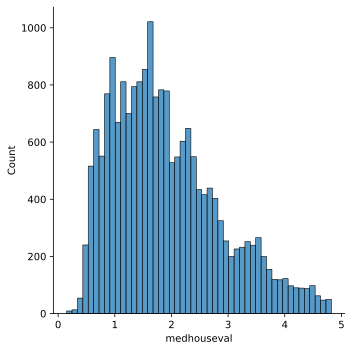

In [ ]:
sns.displot(df.medhouseval);

In [ ]:
# проверим пропуски
df.isna().mean().sort_values()

medinc        0.00
houseage      0.00
averooms      0.00
avebedrms     0.00
population    0.00
aveoccup      0.00
medhouseval   0.00
dtype: float64

In [ ]:
# какие типы есть в датафрейме
df.dtypes.value_counts()

float64    7
Name: count, dtype: int64

In [ ]:
# создадим новую переменную
df['avebedrms_averooms'] = df['avebedrms'] / df['averooms']

In [ ]:
# посчитаем статистики для переменных
df.describe(include='all')

,medinc,houseage,averooms,avebedrms,population,aveoccup,medhouseval,avebedrms_averooms
count,19569.00,19569.00,19569.00,19569.00,19569.00,19569.00,19569.00,19569.00
mean,3.67,28.35,5.36,1.10,1442.79,3.10,1.91,0.22
std,1.56,12.50,2.29,0.45,1145.01,10.66,0.95,0.06
min,0.50,1.00,0.85,0.33,3.00,0.69,0.15,0.10
25%,2.52,18.00,4.41,1.01,797.00,2.45,1.16,0.18
50%,3.44,28.00,5.18,1.05,1181.00,2.84,1.73,0.20
75%,4.57,37.00,5.97,1.10,1749.00,3.31,2.47,0.24
max,15.00,52.00,132.53,34.07,35682.00,1243.33,4.82,1.00


>В данных не обнаружены пропуски и выбросы

**Разделим данные на обучающую и тестовую выборки**

**Вопрос**: Почему стоит дополнительно отделять тестовую выборку?

**Вопрос**: Обратите внимание на фиксацию `random_state` при сплите данных. Почему это важно?

In [ ]:
y = df['medhouseval']
X = df.drop(columns= 'medhouseval')

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=10)

Обучить линейную регрессию на признаках из нашего датасета.

В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) &mdash; "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$

У моделей из `sklearn` есть методы `fit` и `predict`.

Метод `fit` принимает на вход обучающую выборку и вектор целевых переменных и обучает модель

метод `predict` может быть вызван только после обучения модели, то есть только после метода `fit`, метод `predict` возвращает предсказание на выборке.

Обучить нашу первую модель на числовых признаках

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 0.6632
Train RMSE = 0.6701


In [ ]:
y_pred

array([2.54986716, 2.24006099, 2.24338025, ..., 1.18348502, 3.07727479,
       1.03466967])

In [ ]:
y_test

18235   2.94
19160   3.25
11638   2.26
13779   1.07
17504   1.82
        ... 
16599   0.91
10262   2.72
1798    0.87
11470   2.85
13907   0.84
Name: medhouseval, Length: 5871, dtype: float64

Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес &mdash; тем более сильным является признак.

**Вопрос**: Почему это не совсем правда?

In [ ]:
model.coef_

array([ 5.40138403e-01,  1.45875464e-02, -4.32843364e-02,  1.73200882e-01,
        2.36337576e-05, -4.78098007e-03,  4.17389932e+00])

In [ ]:
def show_weights(features, weights, means, scales):
    fig, axs = plt.subplots(figsize=(9, 5), ncols=3)
    sorted_weights = sorted(zip(weights, features, means, scales), reverse=True)
    weights, features, means, scales = zip(*sorted_weights)
    features = list(features)

    sns.barplot(y=features, x=list(weights), ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=list(means), ax=axs[1])
    axs[1].set_xlabel("Mean")
    sns.barplot(y=features, x=list(scales), ax=axs[2])
    axs[2].set_xlabel("Scale")
    plt.tight_layout()

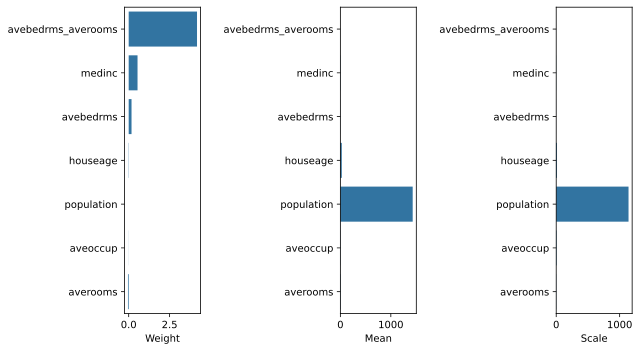

In [ ]:
show_weights(X_train.columns, model.coef_, X_train.mean(), X_train.std())

In [ ]:
sorted(model.coef_)

[-0.04328433637882113,
 -0.0047809800658983196,
 2.363375760090075e-05,
 0.0145875463668149,
 0.17320088248323454,
 0.5401384034163238,
 4.173899317324649]

In [ ]:
X_train.describe()

,medinc,houseage,averooms,avebedrms,population,aveoccup,avebedrms_averooms
count,13698.00,13698.00,13698.00,13698.00,13698.00,13698.00,13698.00
mean,3.66,28.33,5.36,1.10,1433.27,3.07,0.22
std,1.56,12.49,2.41,0.49,1139.85,7.05,0.06
min,0.50,1.00,0.89,0.33,3.00,0.69,0.10
25%,2.52,18.00,4.41,1.01,791.00,2.45,0.18
50%,3.43,28.00,5.19,1.05,1177.00,2.84,0.20
75%,4.58,37.00,5.96,1.10,1734.75,3.30,0.24
max,15.00,52.00,132.53,34.07,35682.00,599.71,1.00


Будем масштабировать наши признаки перед обучением модели.

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

$ \frac {x-срзнач} {сроткл} $

$ \frac {x-min} {max-min}$

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 0.6632
Train RMSE = 0.6701


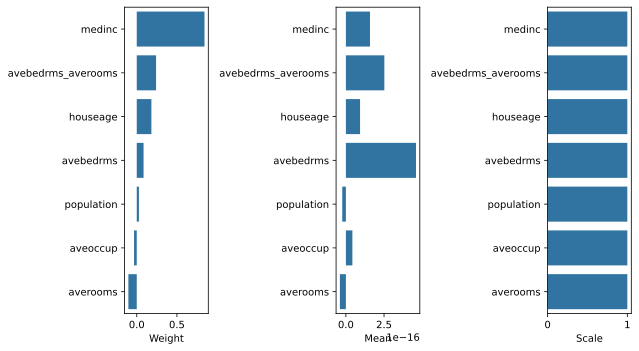

In [ ]:
means = pd.Series(data=X_train_scaled.mean(axis=0), index=X_train.columns)
scales = pd.Series(data=X_train_scaled.std(axis=0), index=X_train.columns)
show_weights(X_train.columns, model.coef_, means, scales)

# Обучение SGDRegressor
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor

Этот класс реализует стохастический градиентный спуск (SGD) для решения задачи линейной регрессии.

In [ ]:
# ?SGDRegressor

In [ ]:
# sgd_reg = SGDRegressor(max_iter=100000, penalty=None, n_iter_no_change=100, tol=1e-6, random_state=12345)
sgd_reg = SGDRegressor(max_iter=100000, penalty=None, random_state=12345)
sgd_reg.fit(X_train_scaled, y_train)

SGDRegressor(max_iter=100000, penalty=None, random_state=12345)

In [ ]:
y_pred_test_sgd = sgd_reg.predict(X_test_scaled)
y_pred_train_sgd = sgd_reg.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test_sgd, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train_sgd, squared=False))

Test RMSE = 63.1262
Train RMSE = 27.4902


# Кросс валидация

Мы обучили  модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации.


Принцип кросс-валидации изображен на рисунке

<img src="https://docs.splunk.com/images/thumb/e/ee/Kfold_cv_diagram.png/1200px-Kfold_cv_diagram.png" width=50%>

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

In [ ]:
# model = SGDRegressor(max_iter=100000, penalty=None, n_iter_no_change=100, tol=1e-6, random_state=12345)

In [ ]:
model = LinearRegression()

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="neg_root_mean_squared_error")

print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -0.6774
	-0.6769
	-0.6596
	-0.7815
	-0.6646
Mean CV RMSE = 0.6920


Обратите внимание на то, что результаты `cv_scores` получились отрицательными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются `neg_*`, например, `neg_root_mean_squared_error`.

Обратите внимание, что по отложенной выборке и при кросс-валидации мы считаем RMSE (Root Mean Squared Error), хотя в функционале ошибки при обучении модели используется MSE.

$$\text{RMSE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (y_i - a(x_i))^2}$$

**Вопрос**: Почему оптимизация RMSE эквивалентна оптимизации MSE?

Если бы RMSE не входил в стандартные метрики `sklearn`, можно было бы его определить через функцию `sklearn.metrics.make_scorer`.

In [ ]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % abs(x) for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean([abs(x) for x in cv_scores]))

Cross validation scores:
	 0.6926
	0.6609
	0.6885
	0.6639
	0.6657
	0.6536
	0.9142
	0.6792
	0.6797
	0.6463
Mean CV RMSE = 0.6945
